<a href="https://colab.research.google.com/github/cjdolan/HighResolutionSemanticClassification/blob/main/TrainEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 63.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
from collections import defaultdict
import time
from tqdm import tqdm
from urllib.parse import urljoin
from shapely.geometry import Polygon
import numpy as np
from multiprocessing.pool import ThreadPool
import zipfile
from glob import glob
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
import os
import rasterio
import shutil
from matplotlib import pyplot as plt
from rasterio.plot import show
import random
from sklearn.model_selection import train_test_split
from ast import literal_eval
from tqdm.notebook import tqdm
import cv2

# auth.authenticate_user()
# !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
# !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
# !apt -qq update
# !apt -qq install gcsfuse

# !mkdir bucket_data
# !gcsfuse --implicit-dirs atml_bucket bucket_data
# headers = {}
# payload = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FIRST_RUN = False
HAVE_FILES = True

NEW_IMG_SIZE = 3000

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ATML_Dataset_Largest.csv')
df['bbox'] = df['bbox'].apply(lambda x: literal_eval(x))
df['Class'] = df['Class'].apply(lambda x: literal_eval(x))

In [ ]:
df.head()

,Unnamed: 0,fileName,bbox,Class,entity_id,product_id
0,0,M_2509704_SE_14_1_20161206,"[[5739, 3030, 6048, 3297]]",[stadium],2312564.0,5e83a340275f0f2c
1,1,M_2608101_SW_17_1_20171031,"[[78, 917, 2610, 3698]]",[airport],2545525.0,5e83a340275f0f2c
2,2,M_2608126_NW_17_1_20171104,"[[663, 3805, 2246, 5478]]",[airport],2545553.0,5e83a340275f0f2c
3,3,M_2608127_SW_17_1_20171104,"[[-2330, 1771, 1696, 5332]]",[airport],2545403.0,5e83a340275f0f2c
4,4,M_2608214_NE_17_1_20171031,"[[5511, 1748, 7297, 3539]]",[airport],2545600.0,5e83a340275f0f2c


In [ ]:
if not HAVE_FILES:
  IMAGE_DIR = '/content/drive/MyDrive/ATMLData/atml_bucket/'
  fileNames = [x.split('/')[-1].lower() for x in glob(IMAGE_DIR + '*.tif')]

  !rm -r /content/drive/MyDrive/NAIP_Lower_Res_3000_v3
  !mkdir /content/drive/MyDrive/NAIP_Lower_Res_3000_v3
  for idx in tqdm(range(len(fileNames)), position=0, leave=True):
    with rasterio.open(IMAGE_DIR + fileNames[idx]) as img:
      img_new = img.read(out_shape=(img.count, int(3000), int(3000)),
                          resampling=Resampling.bilinear)
      img_new = img_new[0:3,:,:]
      img_new = np.transpose(img_new, (1,2,0))
            

      cv2.imwrite('/content/drive/MyDrive/NAIP_Lower_Res_3000_v3/' + fileNames[idx][:-4] + '.png', img_new)

In [ ]:
if FIRST_RUN:
  def correct_bbox(fileName, bbox, new_size):
    new_bbox = []
    try:
      with rasterio.open('/content/drive/MyDrive/ATMLData/atml_bucket/' + fileName.lower() + '.tif') as img:
        for box in bbox:
          new_box = []
          y_old = img.shape[0]
          x_old = img.shape[1]

          for i in range(4):
            old = None
            if i % 2 == 0:
              old = x_old
            else:
              old = y_old
            new_val = int((float(box[i]) / float(old)) * new_size)
            if new_val < 0:
              new_val = 0
            elif new_val > new_size:
              new_val = new_size
            new_box.append(new_val)


          new_bbox.append(new_box)
    except:
      print('Failed on file ' + str(fileName.lower()))

    return new_bbox

  tqdm.pandas()
  df['bbox'] = df[['fileName', 'bbox']].progress_apply(lambda x: correct_bbox(x.fileName, x.bbox, NEW_IMG_SIZE), axis=1)
  df.to_csv('/content/drive/MyDrive/ATML_Dataset_' + str(NEW_IMG_SIZE)  + '.csv')

  import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ATML_Dataset_' + str(NEW_IMG_SIZE) + '.csv')
df['bbox'] = df['bbox'].apply(lambda x: literal_eval(x))
df['Class'] = df['Class'].apply(lambda x: literal_eval(x))
encodings = {'airport':0, 'stadium':1, 'power_plant':2}

df['Label'] = df['Class'].apply(lambda x: [encodings[y] for y in x])

In [ ]:
new_df = pd.DataFrame(columns=df.columns)
idx = 0
for index, row in tqdm(df.iterrows(), position=0, leave=True):
  if len(row.bbox) > 0:
    for i in range(len(row.bbox)):
      new_df.at[idx, 'fileName'] = row.fileName + '_' + str(i)
      new_df.at[idx, 'bbox'] = row.bbox[i]
      new_df.at[idx, 'Class'] = row.Class[i]
      new_df.at[idx, 'Label'] = row.Label[i]
      idx += 1
df = new_df

0it [00:00, ?it/s]

In [ ]:
df.shape

(2836, 8)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,fileName,bbox,Class,entity_id,product_id,Label
0,NaN,NaN,M_2509704_SE_14_1_20161206_0,"[2472, 1192, 2606, 1297]",stadium,NaN,NaN,1
1,NaN,NaN,M_2608101_SW_17_1_20171031_0,"[34, 363, 1141, 1465]",airport,NaN,NaN,0
2,NaN,NaN,M_2608126_NW_17_1_20171104_0,"[289, 1509, 980, 2172]",airport,NaN,NaN,0
3,NaN,NaN,M_2608127_SW_17_1_20171104_0,"[0, 702, 741, 2116]",airport,NaN,NaN,0
4,NaN,NaN,M_2608214_NE_17_1_20171031_0,"[2402, 691, 3000, 1399]",airport,NaN,NaN,0


Import PyTorch libraries for building vision autoencoder

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

0.9450980392156862


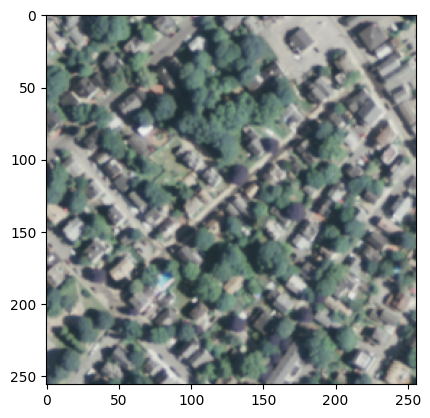

<class 'numpy.float64'>


In [ ]:
with rasterio.open(IMAGE_DIR + fileNames[50]) as img:
  img = img.read(window=((0, 256), (0, 256))) / 255
  print(np.max(img))
  show(img[0:3,0:256,0:256])
  print(type(img[0,0,0]))
  np.save('/content/test',img)

In [ ]:
PATCH_SIZE = 256

In [ ]:
img = cv2.imread('/content/drive/MyDrive/ATMLDataPatches/' + fileNames[0][:-4] + '_' + str(0) + '.png')
np.transpose(img, (2,0,1)).shape
print(type(img[0,0,0]))

NameError: ignored

In [ ]:
pd.DataFrame()

""


In [ ]:
PATCH_SIZE=256

In [ ]:
from rasterio.enums import Resampling

In [ ]:
a = 6540
b = 2000 / a
print(int(a * b))

1999


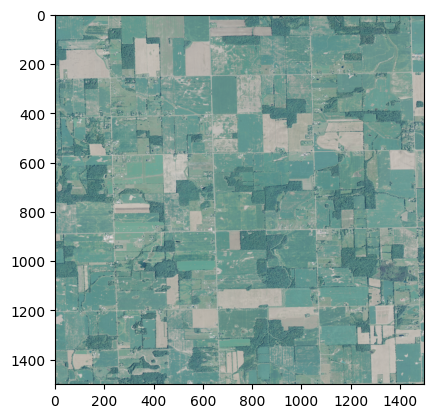

In [ ]:
idx = 200
with rasterio.open(IMAGE_DIR + fileNames[idx]) as img:
      img_new = img.read()
      show(img_new[0:3])

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/NAIP_Lower_Res_' + str(NEW_IMG_SIZE) + '_v3/'
fileNames = [x.split('/')[-1].lower() for x in glob(IMAGE_DIR + '*.png')]

In [ ]:
print(len(fileNames))

2141


In [ ]:
dims = {0:[0,0], 1:[0,0], 2:[0,0]}
dim_counts = {0:0,1:0,2:0}
for index, row in tqdm(df.iterrows(), total=df.shape[0], position=0, leave=True):
  dims[row.Label][0] += (row.bbox[2] - row.bbox[0])
  dims[row.Label][1] += (row.bbox[3] - row.bbox[1])
  if (row.bbox[2] - row.bbox[0]) < 0:
    print('Broken x')
  if (row.bbox[3] - row.bbox[1]) < 0:
    print('Broken y')
  dim_counts[row.Label] += 1
for k in dims.keys():
  print('Label ' + str(k) + ' dims:')
  print('Average x size = ' + str(dims[k][0]/dim_counts[k]))
  print('Average y size = ' + str(dims[k][1]/dim_counts[k]))

  0%|          | 0/2836 [00:00<?, ?it/s]

Broken x
Label 0 dims:
Average x size = 409.2559598494354
Average y size = 372.23588456712673
Label 1 dims:
Average x size = 78.57229437229437
Average y size = 68.2034632034632
Label 2 dims:
Average x size = 146.10294117647058
Average y size = 120.07918552036199


In [ ]:
PATCH_SIZES = {0:512,1:256,2:256}
PADDING = 24

In [ ]:
from PIL import Image

In [ ]:
PATCHES = True

Unnamed: 0.1                             NaN
Unnamed: 0                               NaN
fileName        M_3607614_NE_18_1_20160723_0
bbox                [1552, 1512, 1648, 1581]
Class                                stadium
entity_id                                NaN
product_id                               NaN
Label                                      1
Name: 1000, dtype: object


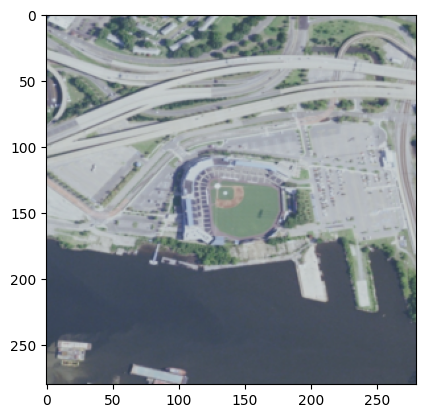

In [ ]:
row = df.iloc[1000]
print(row)
img = cv2.imread(IMAGE_DIR + row.fileName.lower()[:-2] + '.png')
center_x = int((row.bbox[0] + row.bbox[2]) / 2)
center_y = int((row.bbox[1] + row.bbox[3]) / 2)
img = img[center_y - (PATCH_SIZES[row.Label] + PADDING)//2:center_y + (PATCH_SIZES[row.Label] + PADDING)//2, center_x - (PATCH_SIZES[row.Label] + PADDING)//2:center_x + (PATCH_SIZES[row.Label] + PADDING)//2, :]
plt.imshow(img/255.0)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,fileName,bbox,Class,entity_id,product_id,Label
0,NaN,NaN,M_2509704_SE_14_1_20161206_0,"[2472, 1192, 2606, 1297]",stadium,NaN,NaN,1
1,NaN,NaN,M_2608101_SW_17_1_20171031_0,"[34, 363, 1141, 1465]",airport,NaN,NaN,0
2,NaN,NaN,M_2608126_NW_17_1_20171104_0,"[289, 1509, 980, 2172]",airport,NaN,NaN,0
3,NaN,NaN,M_2608127_SW_17_1_20171104_0,"[0, 702, 741, 2116]",airport,NaN,NaN,0
4,NaN,NaN,M_2608214_NE_17_1_20171031_0,"[2402, 691, 3000, 1399]",airport,NaN,NaN,0


In [ ]:
if not PATCHES:
  !rm -r /content/drive/MyDrive/Patches256_v4
  !mkdir /content/drive/MyDrive/Patches256_v4
  for index, row in tqdm(df.iterrows(), total=df.shape[0], position=0, leave=True):
    try:
      img = cv2.imread(IMAGE_DIR + row.fileName.lower()[:-2] + '.png')
      center_x = int((row.bbox[0] + row.bbox[2]) / 2)
      center_y = int((row.bbox[1] + row.bbox[3]) / 2)
      img = img[center_y - (PATCH_SIZES[row.Label] + PADDING)//2:center_y + (PATCH_SIZES[row.Label] + PADDING)//2, center_x - (PATCH_SIZES[row.Label] + PADDING)//2:center_x + (PATCH_SIZES[row.Label] + PADDING)//2, :]
      cv2.imwrite('/content/drive/MyDrive/Patches256_v4/' + row.fileName.lower() + '.png', img)
      del img
    except:
      continue

In [ ]:
print(df.shape)

(2836, 8)


In [ ]:
PATCH_DIR = '/content/drive/MyDrive/Patches256_v4/'
fileNames = [x.split('/')[-1].lower()[:-4] for x in glob(PATCH_DIR + '*.png')]
df.fileName = df['fileName'].apply(lambda x: x.lower())
new_df = df[df.fileName.isin(fileNames)]
df = new_df

In [ ]:
print(df.shape)

(2677, 8)


In [ ]:
class embeddingDataset(Dataset):
  def __init__(self, df, transforms=None):
    self.images = []
    self.transforms = transforms
    for index, row in tqdm(df.iterrows(), total=df.shape[0], position=0, leave=True):
      img = cv2.imread(PATCH_DIR + row.fileName.lower() + '.png') / 255.0
      self.images.append(img)
      del img
      
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    img = Image.fromarray((img * 255).astype(np.uint8)).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    return img/255.0

In [ ]:
from torchvision import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
      transforms.append(T.RandomHorizontalFlip(0.5))
      transforms.append(T.RandomVerticalFlip(0.5))
      transforms.append(T.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(1, 1)))
    else:
      transforms.append(T.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(1, 1)))
    return T.Compose(transforms)

In [ ]:
print(len(glob(PATCH_DIR + '*.png')))

2677


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, 
                                          random_state=42, shuffle=True)

train_transforms = get_transform(True)
val_transforms = get_transform(False)
train_ae_dataset, val_ae_dataset = embeddingDataset(train_df, transforms=train_transforms), embeddingDataset(val_df, transforms=val_transforms)
train_ae_dataloader = DataLoader(train_ae_dataset, batch_size=4, shuffle=True,
                                 pin_memory=True)
val_ae_dataloader = DataLoader(val_ae_dataset, batch_size=4, shuffle=True,
                                 pin_memory=True)

  0%|          | 0/2141 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

In [ ]:
train_ae_dataset[0].detach().numpy().shape

(536, 536, 3)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(3, 256, 256)

(536, 536, 3)


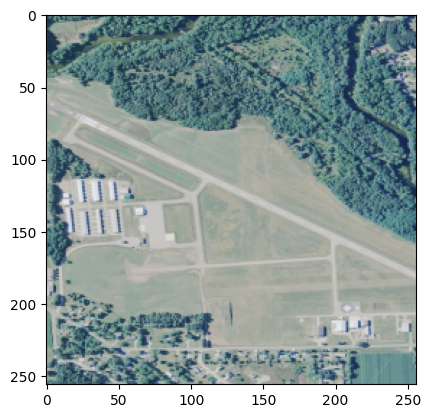

In [ ]:
idx=0
plt.imshow(np.transpose(train_ae_dataset[idx].numpy(), (1,2,0)))

In [ ]:
import torch.nn.functional as F

In [ ]:
class EncoderModule(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.module = nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  (3,3), stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

  def forward(self, X):
    return self.module(X)

class DecoderModule(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.module = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,
                  (3,3), stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, X):
    return self.module(X)

class VAEBase(nn.Module):
  def __init__(self, in_channels, latent_dim, hidden_dims):
    super().__init__()

    self.latent_dims = latent_dim
    self.hidden_dims = hidden_dims

    encoder_modules = []
    for hidden in self.hidden_dims:
      encoder_modules.append(EncoderModule(in_channels, hidden))

      in_channels = hidden

    self.encoder = nn.Sequential(*encoder_modules)

    self.fc_mu = nn.Linear(hidden_dims[-1]*64, latent_dim)
    self.fc_var = nn.Linear(hidden_dims[-1]*64, latent_dim)

    decoder_modules = []

    self.start_decode = nn.Linear(latent_dim, hidden_dims[-1]*64)

    for i in reversed(range(len(hidden_dims)-1)):
      decoder_modules.append(DecoderModule(hidden_dims[i+1],
                                           hidden_dims[i]))
    decoder_modules.append(nn.Sequential(
        nn.ConvTranspose2d(hidden_dims[0], hidden_dims[0], kernel_size=3,
                           stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(hidden_dims[0]),
        nn.LeakyReLU(),
        nn.Conv2d(hidden_dims[0], 3, 3, padding=1),
        nn.Tanh()
    ))

    self.decoder = nn.Sequential(*decoder_modules)

  def forward(self, X):
    encoded = self.encoder(X)
    encoded = torch.flatten(encoded, start_dim=1)
    mu = self.fc_mu(encoded)
    var = self.fc_var(encoded)
    
    std = torch.exp(0.5 * var)
    eps = torch.randn_like(std)

    z = eps * std + mu
    z = self.start_decode(z)
    z = z.view(-1, 512, 8, 8)
    decoded = self.decoder(z)

    return decoded, X, mu, var

In [ ]:
VAE = VAEBase(3, 12288, [32,64,128,256,512]).cuda()

In [ ]:
def read_data(X):
  return X.cuda()

In [ ]:
def loss_function(decoded, input, mu, var):
  decoded = decoded
  input = input
  mu = mu
  var = var
  kld_weight = 0.5
  recons_loss =F.mse_loss(decoded, input)


  kld_loss = torch.mean(-0.5 * torch.sum(1 + var - mu ** 2 - var.exp(), dim = 1), dim = 0)
  # print(recons_loss)
  # print(kld_loss)
  loss = recons_loss + kld_weight * kld_loss
  return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}


In [ ]:
def train(model, train_loader, val_loader, epochs=300, lr=0.0001):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5),int(epochs*0.75)], gamma=0.1)
  # loss_fn = nn.CrossEntropyLoss()
  loss_fn = loss_function
  training_data = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Val Loss'])
  for e in range(epochs):
    model.train()
    tbar = tqdm(train_loader, position=0, leave=True)
    
    start = time.time()
    train_loss_temp = []

    correct = 0
    total = 0
    for batch, (X) in enumerate(tbar):
      img = read_data(X)

      optimizer.zero_grad()
      decoded, input, mu, var = model(img)
      loss = loss_fn(decoded, input, mu, var)
      losses = loss['loss']
      losses.backward()
      optimizer.step()

      train_loss_temp.append(losses.detach().cpu().numpy().ravel())

      tbar.set_description('Epoch: %i, Loss: %f' % (e+1, np.round(np.mean(train_loss_temp),4)))

    model.eval()
    vbar = tqdm(val_loader, position=0, leave=True)
    val_loss_temp = []
    with torch.no_grad():
      for batch, (X) in enumerate(vbar):
        img = read_data(X)

        decoded, input, mu, var = model(img)
        loss = loss_fn(decoded, input, mu, var)
        loss = loss['loss']
        val_loss_temp.append(loss.detach().cpu().numpy().ravel())

        vbar.set_description('Epoch: %i, Val Loss: %f' % (e+1, np.round(np.mean(val_loss_temp),4)))
    
    end = time.time()
    training_data.at[e, 'Epoch'] = e+1
    training_data.at[e, 'Train Loss'] = np.round(np.mean(train_loss_temp),4)
    training_data.at[e, 'Val Loss'] = np.round(np.mean(val_loss_temp),4)
    scheduler.step()

  return training_data

In [24]:
train(VAE, train_ae_dataloader, val_ae_dataloader, 100, 0.00005)

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

,Epoch,Train Loss,Val Loss
0,1,62.587799,20.854799
1,2,4.6422,4.7017
2,3,4.7108,4.8995
3,4,4.328,5.0553
4,5,5.008,14.1234
...,...,...,...
95,96,0.0339,0.0303
96,97,0.0351,0.0368
97,98,0.0398,0.0322
98,99,0.0335,0.0307


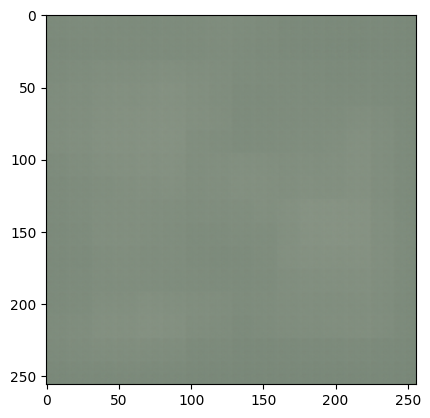

In [ ]:
plt.imshow(np.transpose(VAE(val_ae_dataset[5].unsqueeze(0).cuda())[0].detach().cpu().numpy().squeeze(), (1,2,0)))

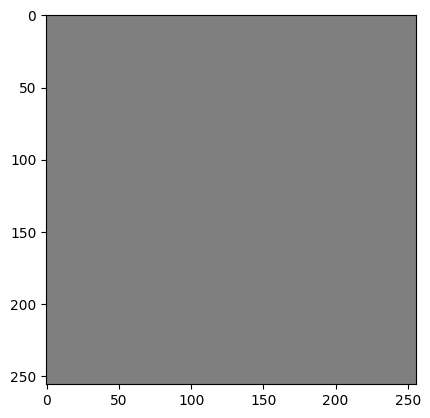

In [ ]:
plt.imshow(np.transpose(VAE(val_ae_dataset[0]).detach().numpy(), (1,2,0)))

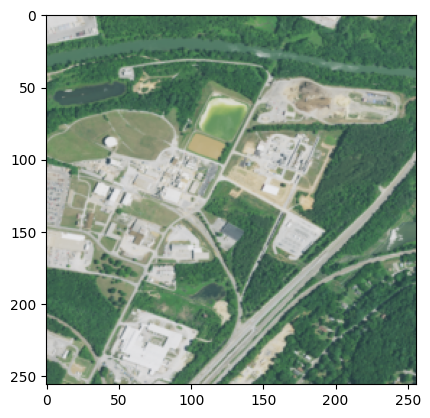

In [ ]:
plt.imshow(np.transpose(val_ae_dataset[0], (1,2,0)))